# Model for "Tsyfra"

The task consists in preparation of a prototype of model of machine learning for "Tsifra". The company develops decisions for effective work of the industrial enterprises. The model has to predict coefficient of restoration of gold from gold-bearing ore. At our disposal data with parameters of production and cleaning. The model will help to optimize production not to start the enterprise with unprofitable characteristics.

## Description of data

- Rougher feed is initial raw materials
- Rougher additions (or reagent additions) is floatation reagents: Xanthate, Sulphate, Depressant
- Xanthate ** — xanthogenate (a promoter, or the flotation activator);
- Sulphate is sulfate (on this production sodium sulfide);
- Depressant is a depressant (sodium silicate).
- Rougher process (English "rough process") is flotation
- Rougher tails is dump tails
- Float banks is floatation installation
- Cleaner process is cleaning
- Rougher Au is a draft concentrate of gold
- Final Au is a final concentrate of gold
- Parameters of stages
- air amount is air volume
- fluid levels is liquid level
- feed size is the size of granules of raw materials

# Data preparation

In [95]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:.3f}'.format

%matplotlib inline
%config InlineBackend.figure_format='retina'

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.base import clone
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


import warnings
import seaborn as sns
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

In [96]:
cwd = os.getcwd()

In [97]:
try:
    df_full = pd.read_csv(cwd + '/gold_recovery_full_new.csv')
    df_train = pd.read_csv(cwd + '/gold_recovery_train_new.csv')
    df_test = pd.read_csv(cwd + '/gold_recovery_test_new.csv')
except:
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

In [98]:
df_full.shape, df_train.shape, df_test.shape

((19439, 87), (14149, 87), (5290, 53))

## Calculation of efficiency

In [99]:
def calc_recovery_effectiveness(row):
    inputed = row['rougher.input.feed_au']
    recovered = row['rougher.output.concentrate_au']
    tail = row['rougher.output.tail_au']
    result = ((recovered * (inputed - tail)) / (inputed * (recovered - tail))) * 100
    return result

In [100]:
calc_recovery = df_train.apply(calc_recovery_effectiveness, axis=1)

In [101]:
mean_absolute_error(calc_recovery, df_train['rougher.output.recovery'])

9.682896147825551e-15

The error is close to equal which means <code> recovery </code> is correct

In [102]:
#let's find the columns which are not in the test
columns_not_in_test = set(df_train) - set(df_test)

In [103]:
columns_not_in_test

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In the following columns

<code>'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio'</code>
 
represent the calculation of proportions of different elements at the first stage of ore processing and in the rest quantity of different elements for all stages of processing.

These traits were most likely not specifically included in the test sample so that the model could be checked without data leakage.

We are interested in <code> 'rougher.output.concentrate _ au' </code > and <code> 'final.output.concentrate_ au' </code> and since it is not included in the test sample,  we will take it from the full dataframe that contains all the data.

From the train sample, we will remove all columns which are not in the test sample except for the target one and we will train the model on the reduced dataframe.

## Preprocessing

Let's replace the index with the date

In [104]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_full['date'] = pd.to_datetime(df_full['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

In [105]:
df_train = df_train.set_index('date')
df_full = df_full.set_index('date')
df_test = df_test.set_index('date')

In [106]:
#Check for nans
def na_describe(df):
    na_df = pd.concat([df.isna().sum(), df.isna().sum()/len(df)*100], axis=1)
    na_df.columns = ["missing count", "missing %"]
    na_df = na_df[na_df["missing count"] > 0]
    na_df = na_df.sort_values(by="missing %", ascending=False)
    if na_df.empty:
        return f'The dataset has no missing values'
    return na_df

In [107]:
display(na_describe(df_train), na_describe(df_full), na_describe(df_test))

,missing count,missing %
secondary_cleaner.output.tail_sol,1605,11.344
rougher.state.floatbank10_e_air,436,3.081
rougher.input.floatbank11_xanthate,428,3.025
primary_cleaner.output.concentrate_sol,286,2.021
secondary_cleaner.state.floatbank2_a_air,217,1.534
...,...,...
rougher.state.floatbank10_a_air,1,0.007
rougher.state.floatbank10_a_level,1,0.007
rougher.state.floatbank10_b_air,1,0.007
rougher.state.floatbank10_b_level,1,0.007


,missing count,missing %
secondary_cleaner.output.tail_sol,1748,8.992
rougher.input.floatbank11_xanthate,453,2.330
rougher.state.floatbank10_e_air,436,2.243
primary_cleaner.output.concentrate_sol,370,1.903
secondary_cleaner.state.floatbank2_a_air,220,1.132
...,...,...
primary_cleaner.state.floatbank8_c_level,1,0.005
primary_cleaner.state.floatbank8_b_level,1,0.005
primary_cleaner.state.floatbank8_a_level,1,0.005
final.output.tail_ag,1,0.005


,missing count,missing %
rougher.input.floatbank11_xanthate,25,0.473
rougher.input.feed_sol,21,0.397
secondary_cleaner.state.floatbank3_a_air,9,0.170
rougher.input.floatbank11_sulfate,8,0.151
primary_cleaner.input.depressant,5,0.095
rougher.input.floatbank10_sulfate,5,0.095
primary_cleaner.input.sulfate,4,0.076
primary_cleaner.input.xanthate,4,0.076
rougher.input.feed_rate,3,0.057
secondary_cleaner.state.floatbank2_a_air,3,0.057


Let's deal with the empty values in the main dataframe. All blank values less than 3% will simply be deleted, this will not greatly affect further analysis. But first, fill the Nan-s in the secondary_cleaner.output.tail_sol with average value

In [108]:
mean = df_full['secondary_cleaner.output.tail_sol'].mean()
df_full['secondary_cleaner.output.tail_sol'] = df_full['secondary_cleaner.output.tail_sol'].fillna(mean)

In [109]:
df_full = df_full.dropna(axis=0)

In [110]:
na_describe(df_full)

'The dataset has no missing values'

In [111]:
main_columns = ['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',]

In [112]:
train_index = list(set(df_full.index).intersection(df_train.index))
test_index = list(set(df_full.index).intersection(df_test.index))

In [113]:
df_train = df_full.loc[train_index].drop(columns_not_in_test, axis=1)
df_test = df_full.loc[test_index].drop(columns_not_in_test, axis=1)

In [114]:
na_describe(df_train)

'The dataset has no missing values'

In [115]:
na_describe(df_test)

'The dataset has no missing values'

In [116]:
df_train.shape, df_test.shape

((12245, 52), (5145, 52))

In [117]:
df_test.duplicated().sum(), df_full.duplicated().sum(), df_train.duplicated().sum()

(0, 0, 0)

No duplicates found

# Data Analysis

Let's check how does the concentration of (Au, Ag, Pb) vary on different stages of the process

In [118]:
phases = {
    'Rougher': 'rougher',
    'Primary cleaner': 'primary_cleaner',
    'Final result': 'final'
}

In [119]:
def draw_barplot(element):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for i, couple in enumerate(phases.items()):
        axes[i].set_title(couple[0] + ' ' + element, size=14);
        sns.boxplot(couple[1] + '.output.concentrate_' + element , ax=axes[i], data=df_full);
        axes[i].set(xlabel= 'Concentration ' + element);

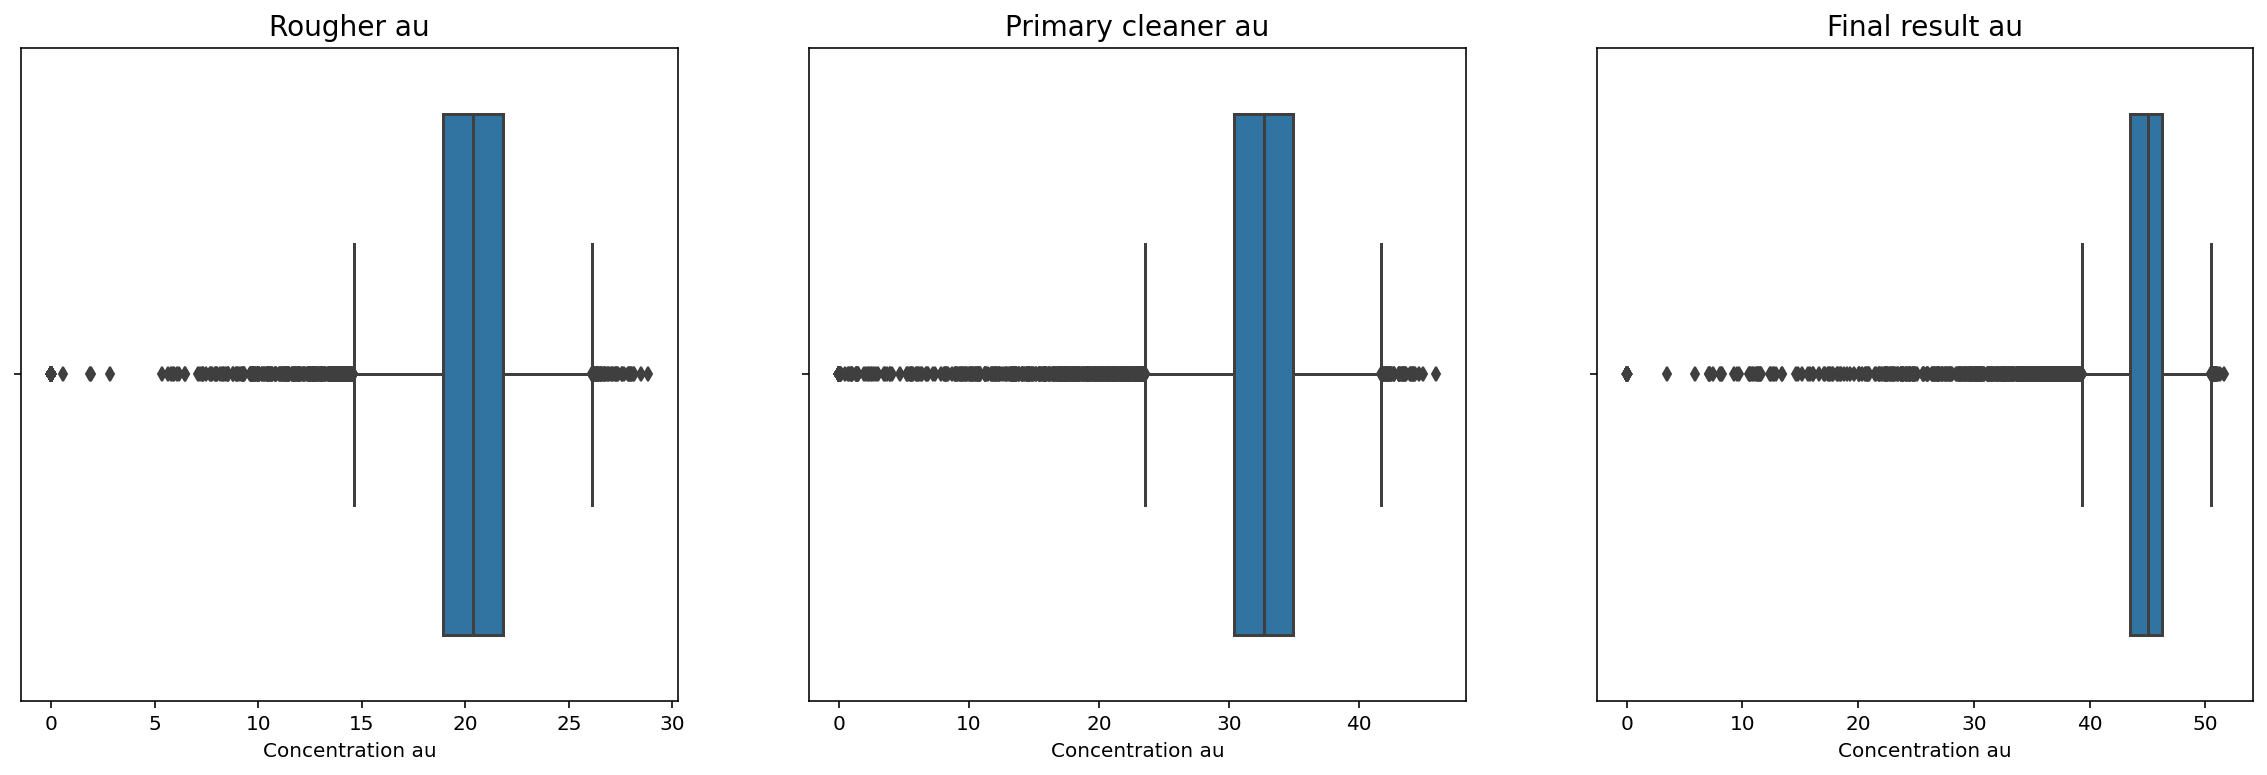

In [120]:
draw_barplot('au')

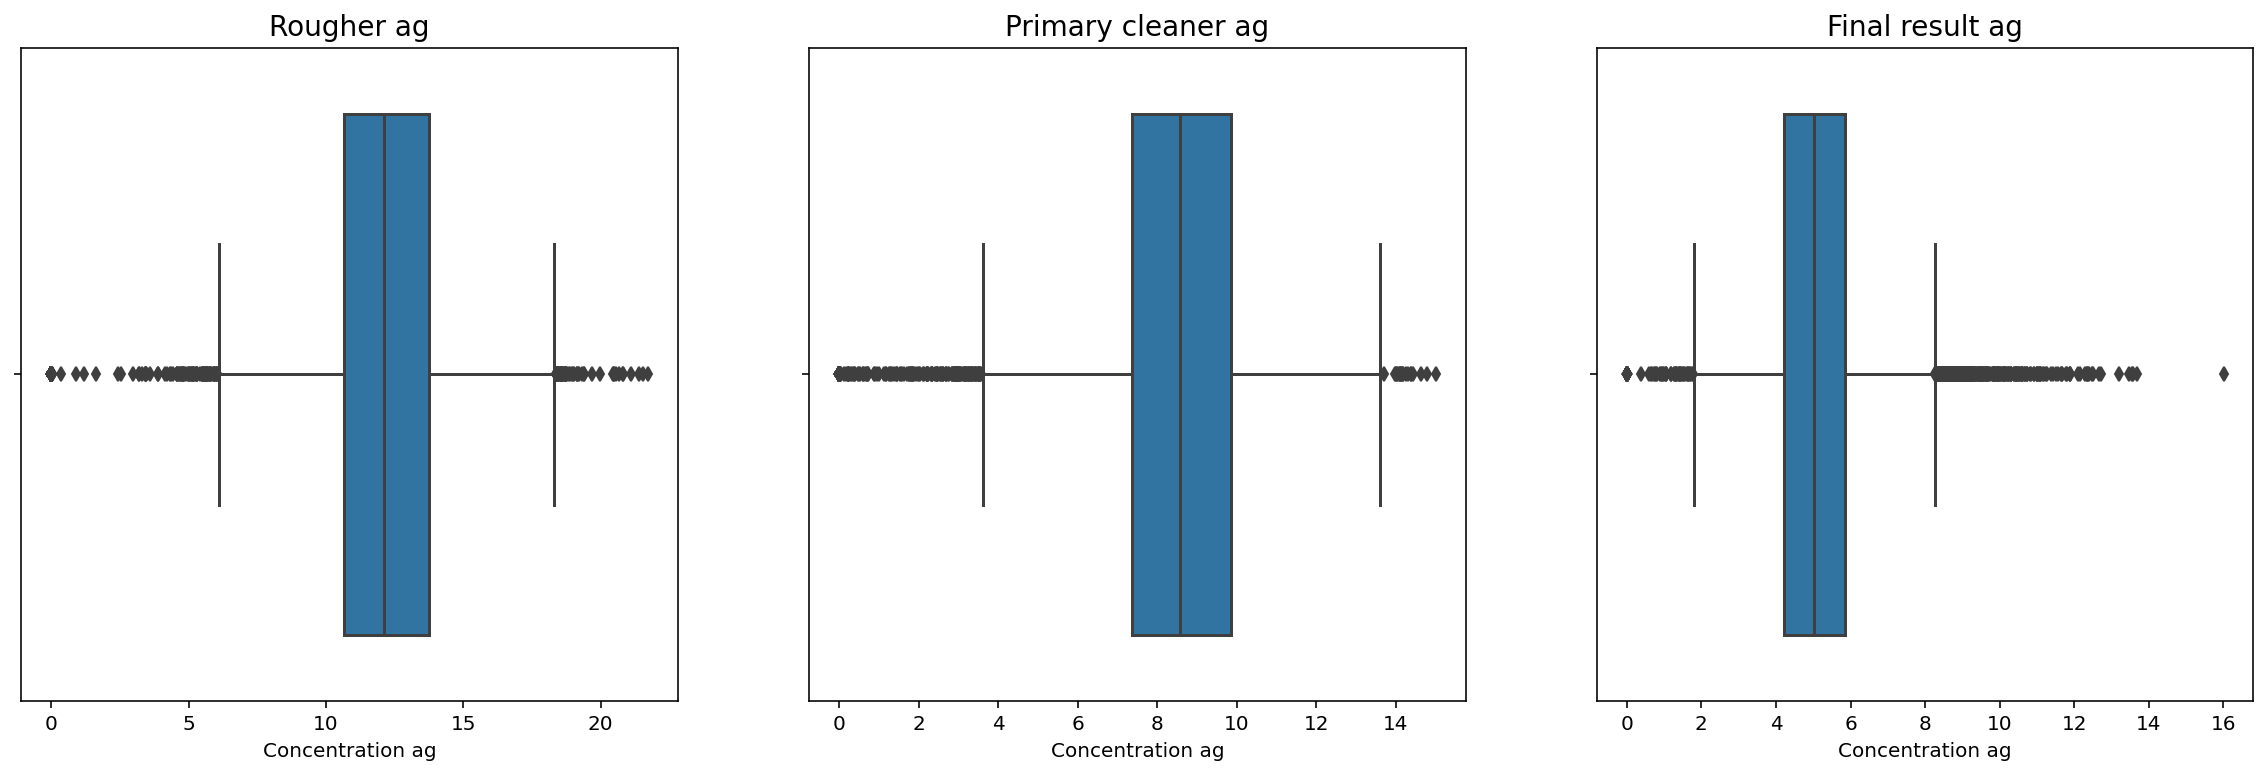

In [121]:
draw_barplot('ag')

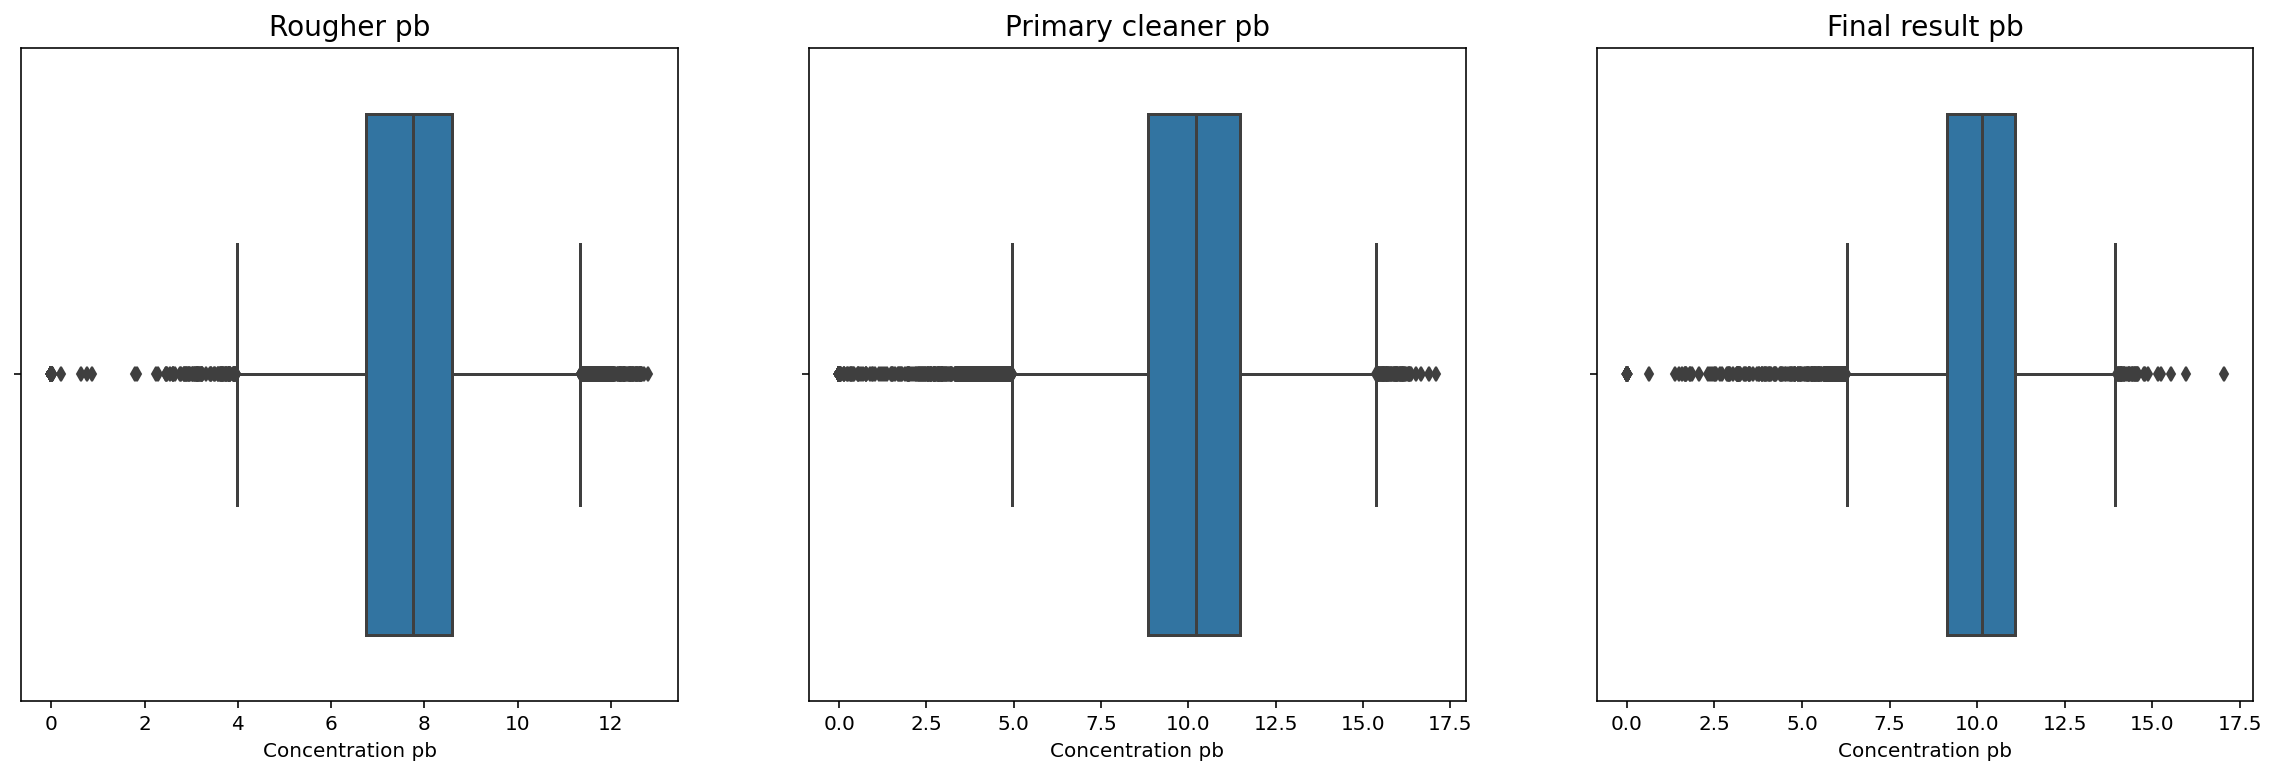

In [122]:
draw_barplot('pb')

Apparently, the concentration is considered in relation to the total number of elements since the figure describing the <code> gold </code> concentration increases after each purification stage. This means that the net gold concentrate becomes larger relative to the total mass.

- Gold concentration increases by more than 2 times relative to total mass after all three filtration steps

For Ag and Pb, the dynamics are very different.

The Ag concentration decreases with each purification step. After three stages of purification, it becomes more than 2 times less than the initial ratio to the total mass.

- The Pb concentration varies slightly between flotation and first purification but remains unchanged after the second purification.

It can also be noted that the gold concentration in general has less variation than the rest of the metals. Most likely because gold concentrate is our target feature and the entire technology of the enterprise is aimed at producing its maximum amount and it is trying to overcome any random factor on the way to the result

# Comparing the feed size

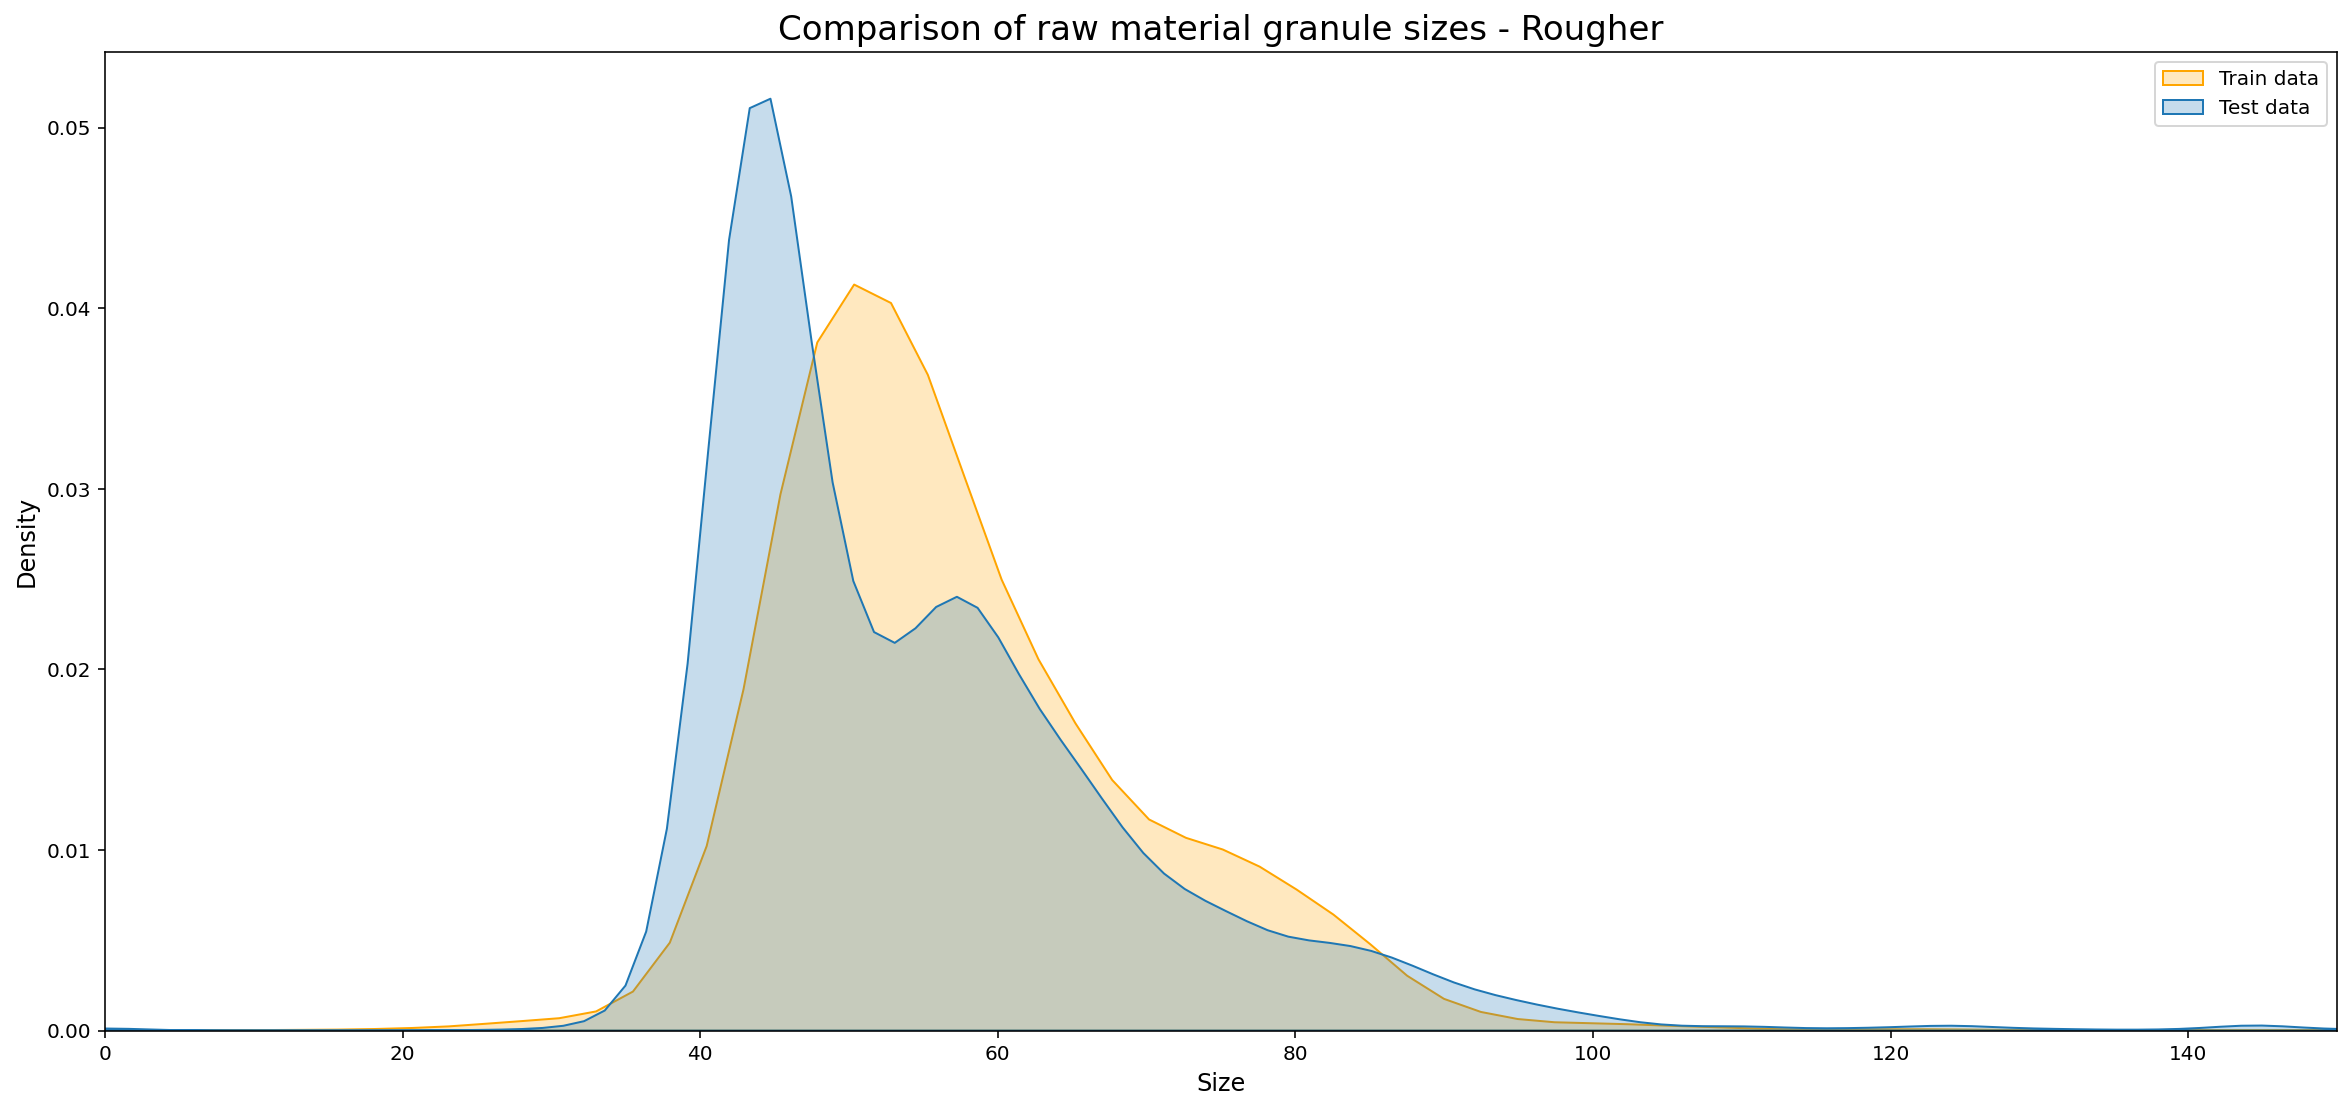

In [123]:
# Сравним сначало размеры перед первой стадии очистки, тоесть перед флотацией
plt.figure(figsize=(20, 9))
sns.kdeplot(df_train['rougher.input.feed_size'], color='orange', shade=True)
sns.kdeplot(df_test['rougher.input.feed_size'], shade=True)
plt.title('Comparison of raw material granule sizes - Rougher', size=17)
plt.xlabel('Size', size=12)
plt.ylabel('Density', size=12)
plt.xlim(0, 150)
plt.legend(['Train data', 'Test data']);

The comparison of distributions shows that two samples have different distributions:

- In the test sample, the distribution is skewed to the left and the mode is around 40
- In the training crop, the distribution of the size of the raw material pellets is similar to a normal distribution

The size of the feed pellets is between 30 and 100 for both samples (except for a few emissions)

Let's check for outliers

In [124]:
col = 'primary_cleaner.input.feed_size'

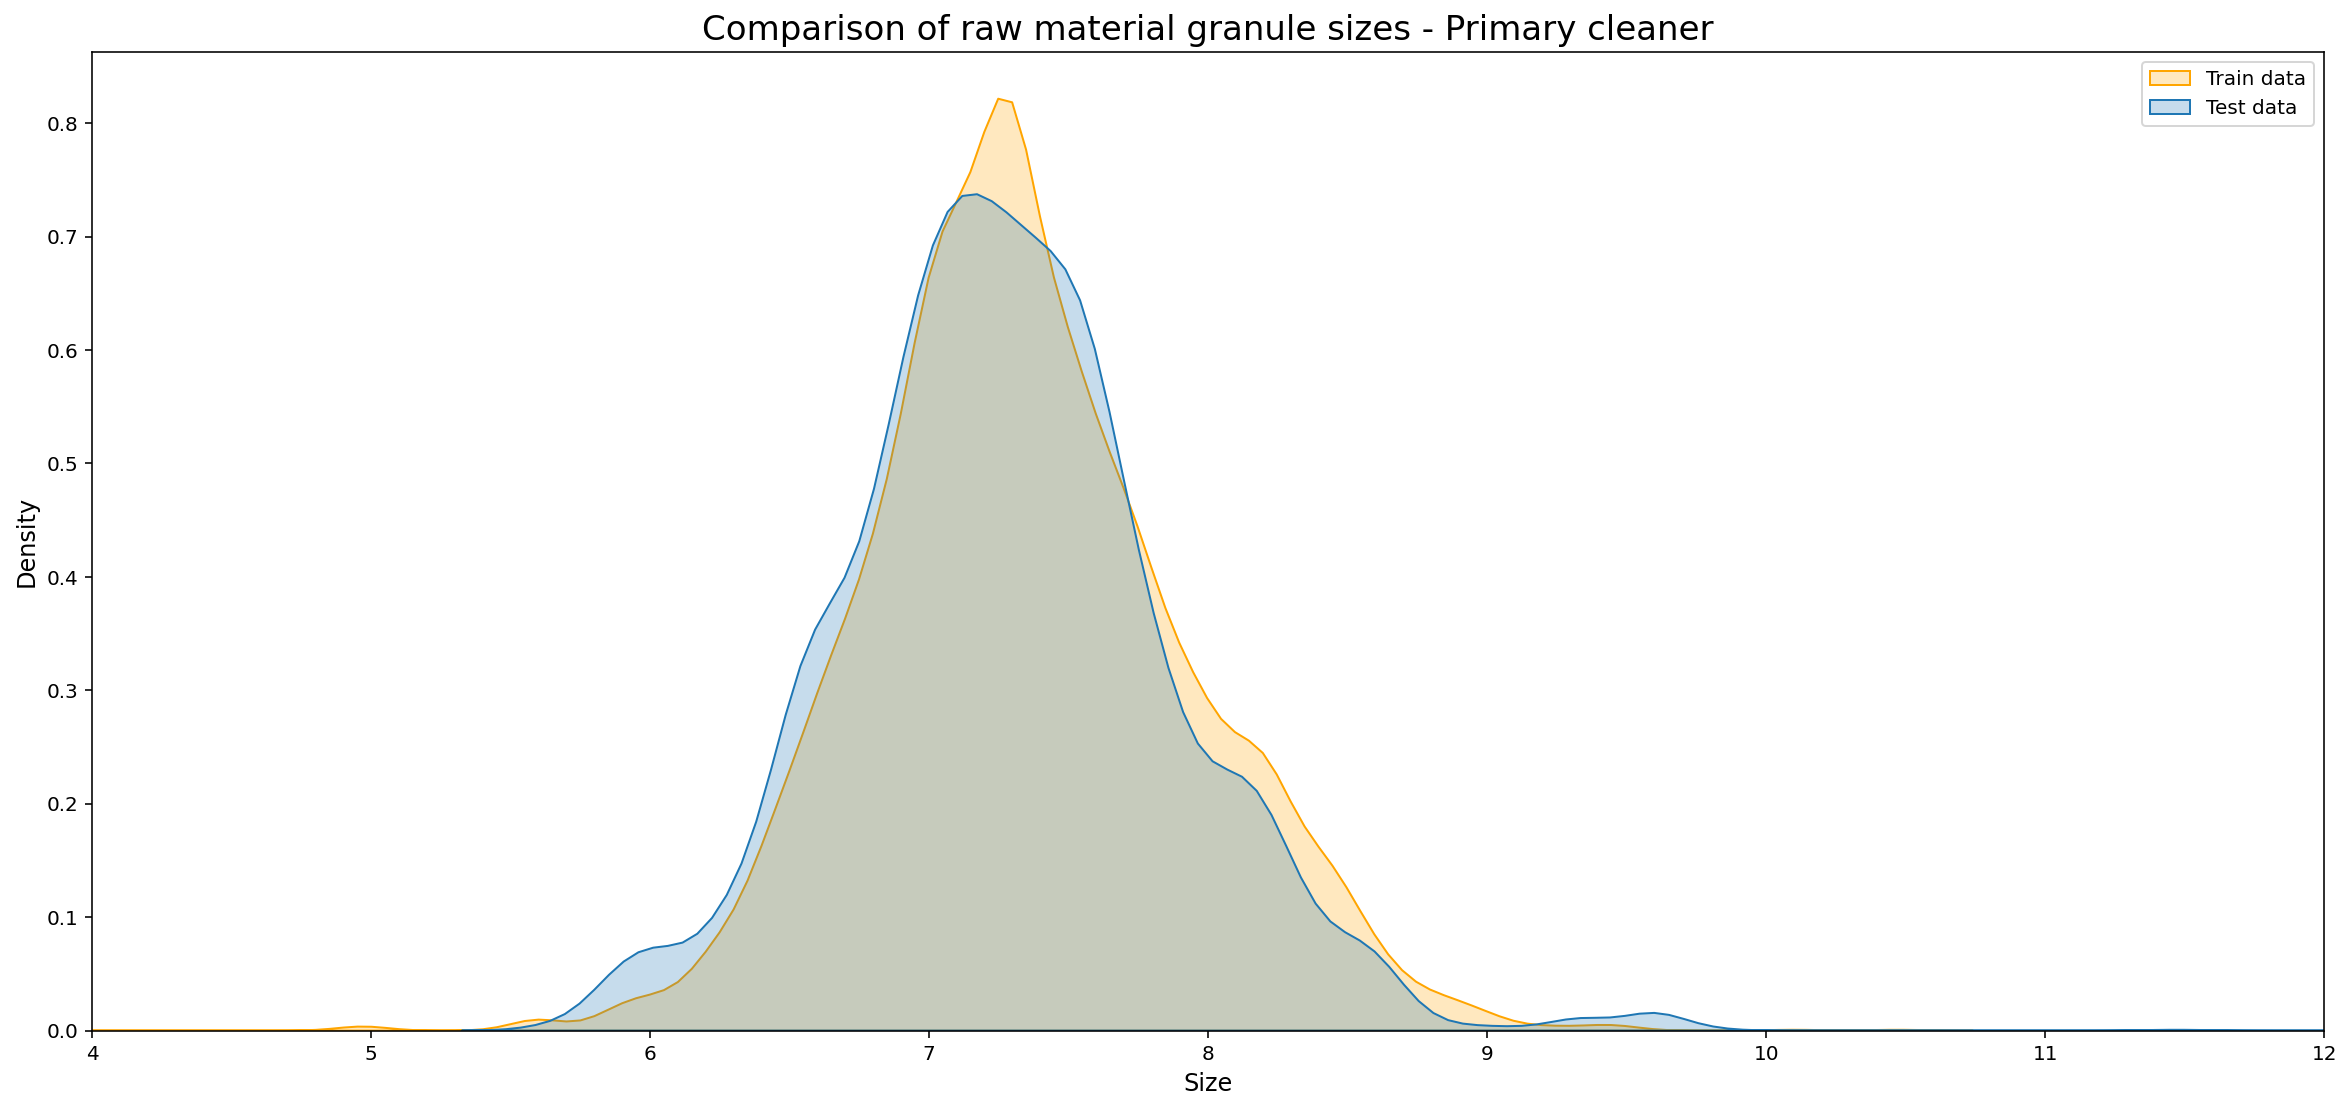

In [125]:
# Let's check granule sizes before the primary cleaner
plt.figure(figsize=(20, 9))
sns.kdeplot(df_train[col], color='orange', shade=True)
sns.kdeplot(df_test[col], shade=True)
plt.title('Comparison of raw material granule sizes - Primary cleaner', size=17)
plt.xlabel('Size', size=12)
plt.ylabel('Density', size=12)
plt.xlim(4, 12)
plt.legend(['Train data', 'Test data']);

In [126]:
display(df_train[col].describe(), df_test[col].describe())

count   12245.000
mean        7.343
std         0.595
min         1.080
25%         6.990
50%         7.300
75%         7.700
max        10.470
Name: primary_cleaner.input.feed_size, dtype: float64

count   5145.000
mean       7.282
std        0.599
min        5.650
25%        6.905
50%        7.250
75%        7.610
max       15.500
Name: primary_cleaner.input.feed_size, dtype: float64

In the second purification step, the pellets have a normal distribution and this is good news. The distribution will not reduce the accuracy of the models. Sizes have almost the same average values ​ ​ in both samples - this is also good.

#  Total concentration analysis

Three pahses interest us:

- Rougher
- Primary cleaner
- Final result

In [127]:
substances = ['au', 'pb', 'sol', 'ag']
phases = ['rougher.input.feed_', 'rougher.output.concentrate_', 'final.output.concentrate_']

In [128]:
def concentrate_plots(column, title):
    
    palette = itertools.cycle(sns.color_palette())

    plt.figure(figsize=(20, 10))
    plt.xlim(0, 52)
    for sub in substances:
        sns.kdeplot(df_full[column + sub], color=next(palette), shade=True)
    plt.legend(['Au', 'Pb', 'Sol', 'Ag'])
    plt.xlabel('Concentrate', size=15)
    plt.ylabel('Density', size=15)
    plt.title(title, size= 18);

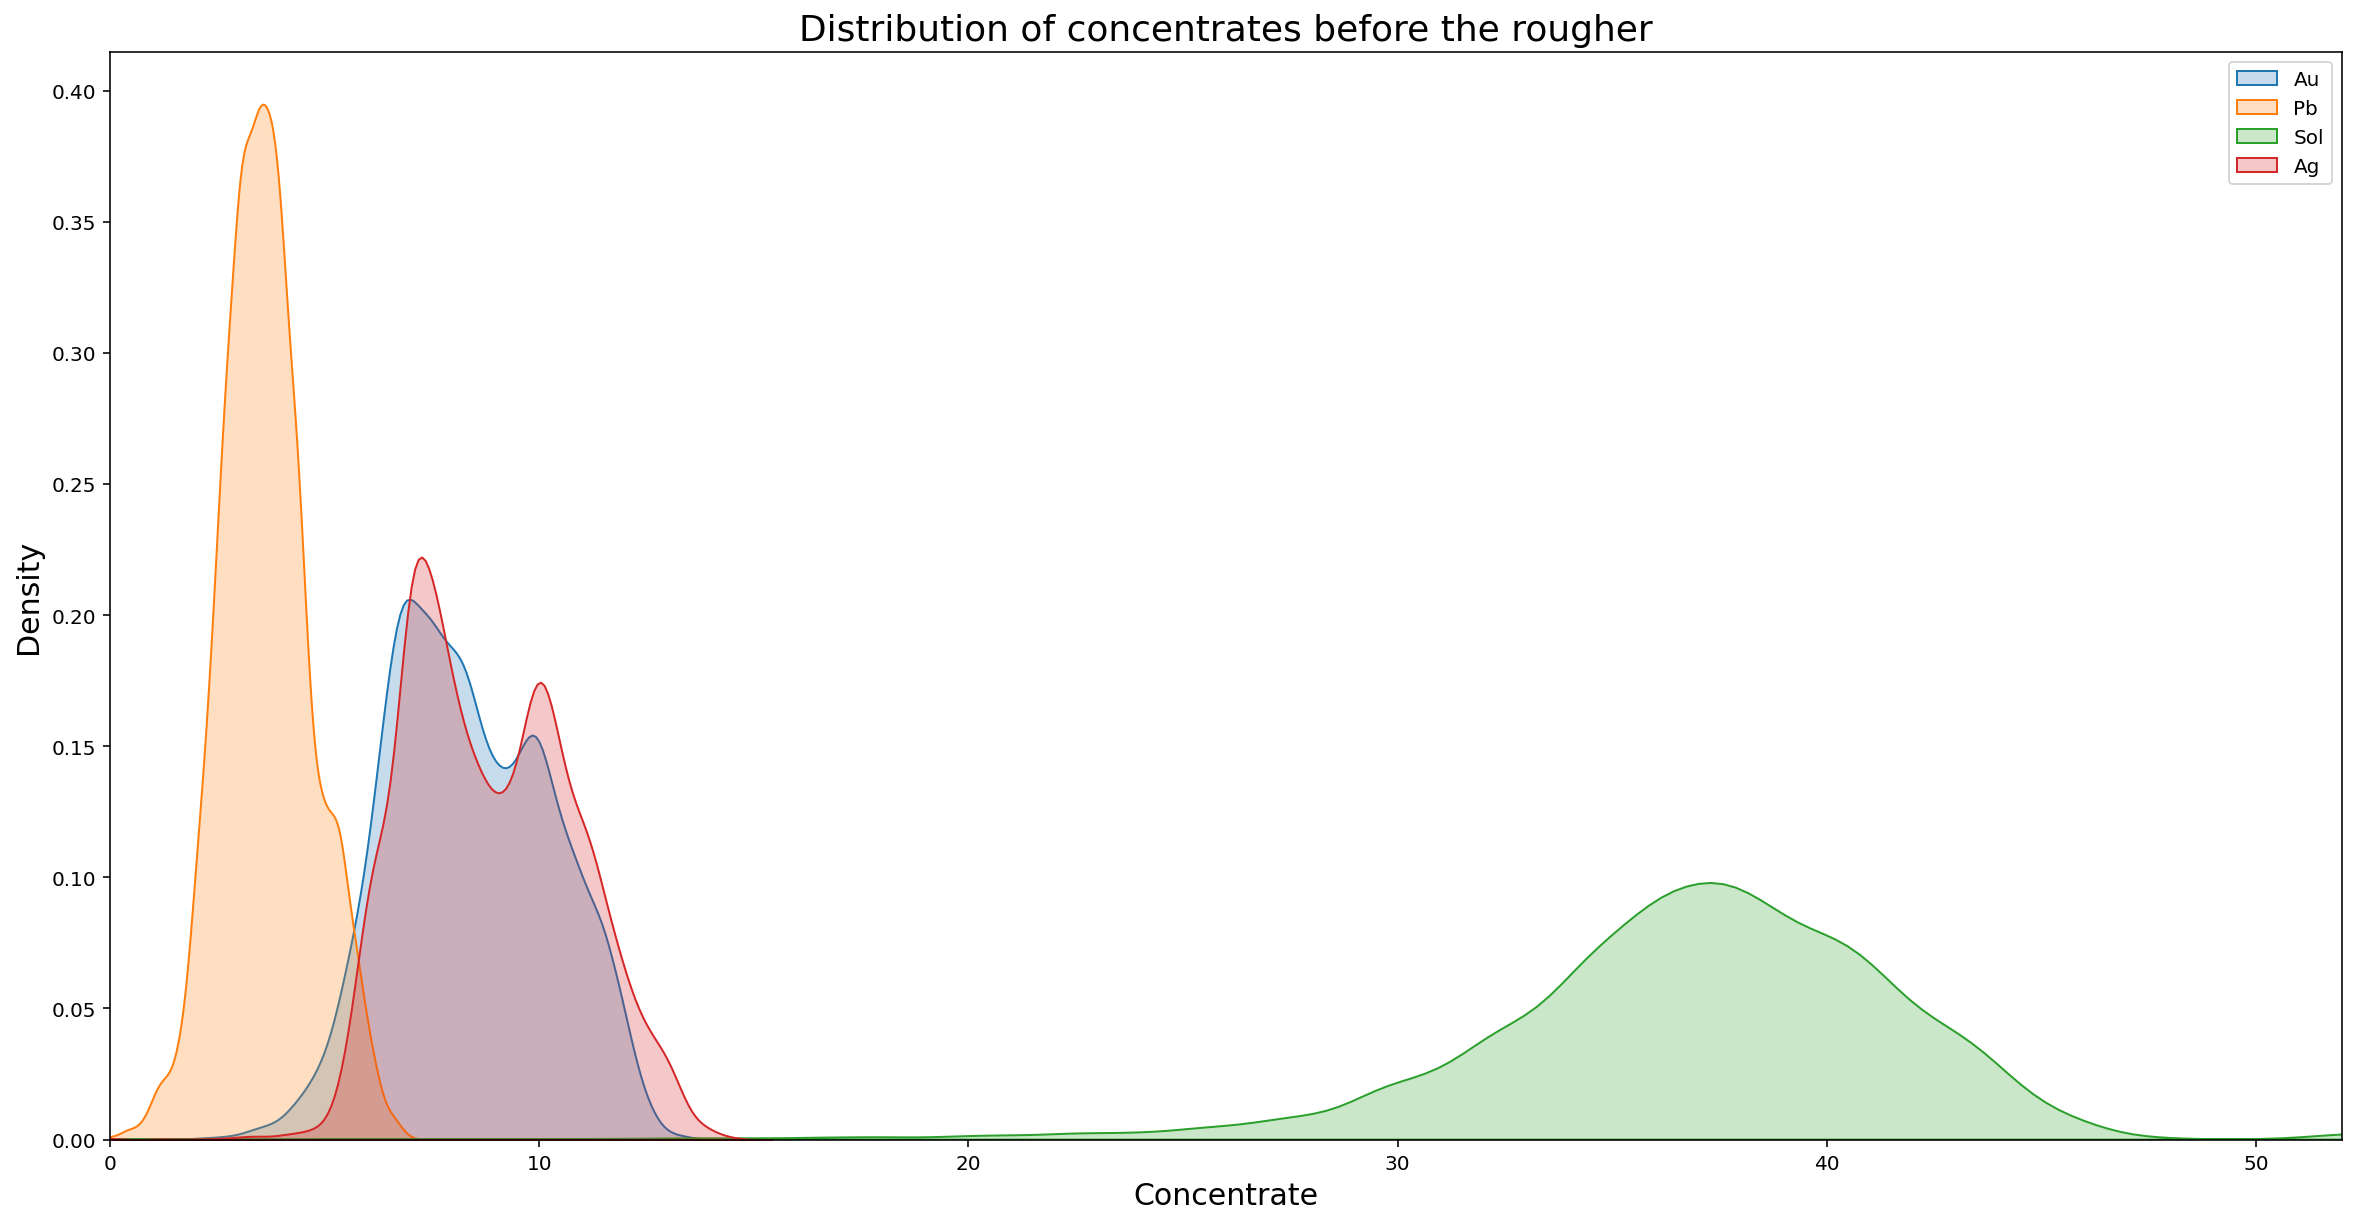

In [129]:
concentrate_plots(phases[0], 'Distribution of concentrates before the rougher')

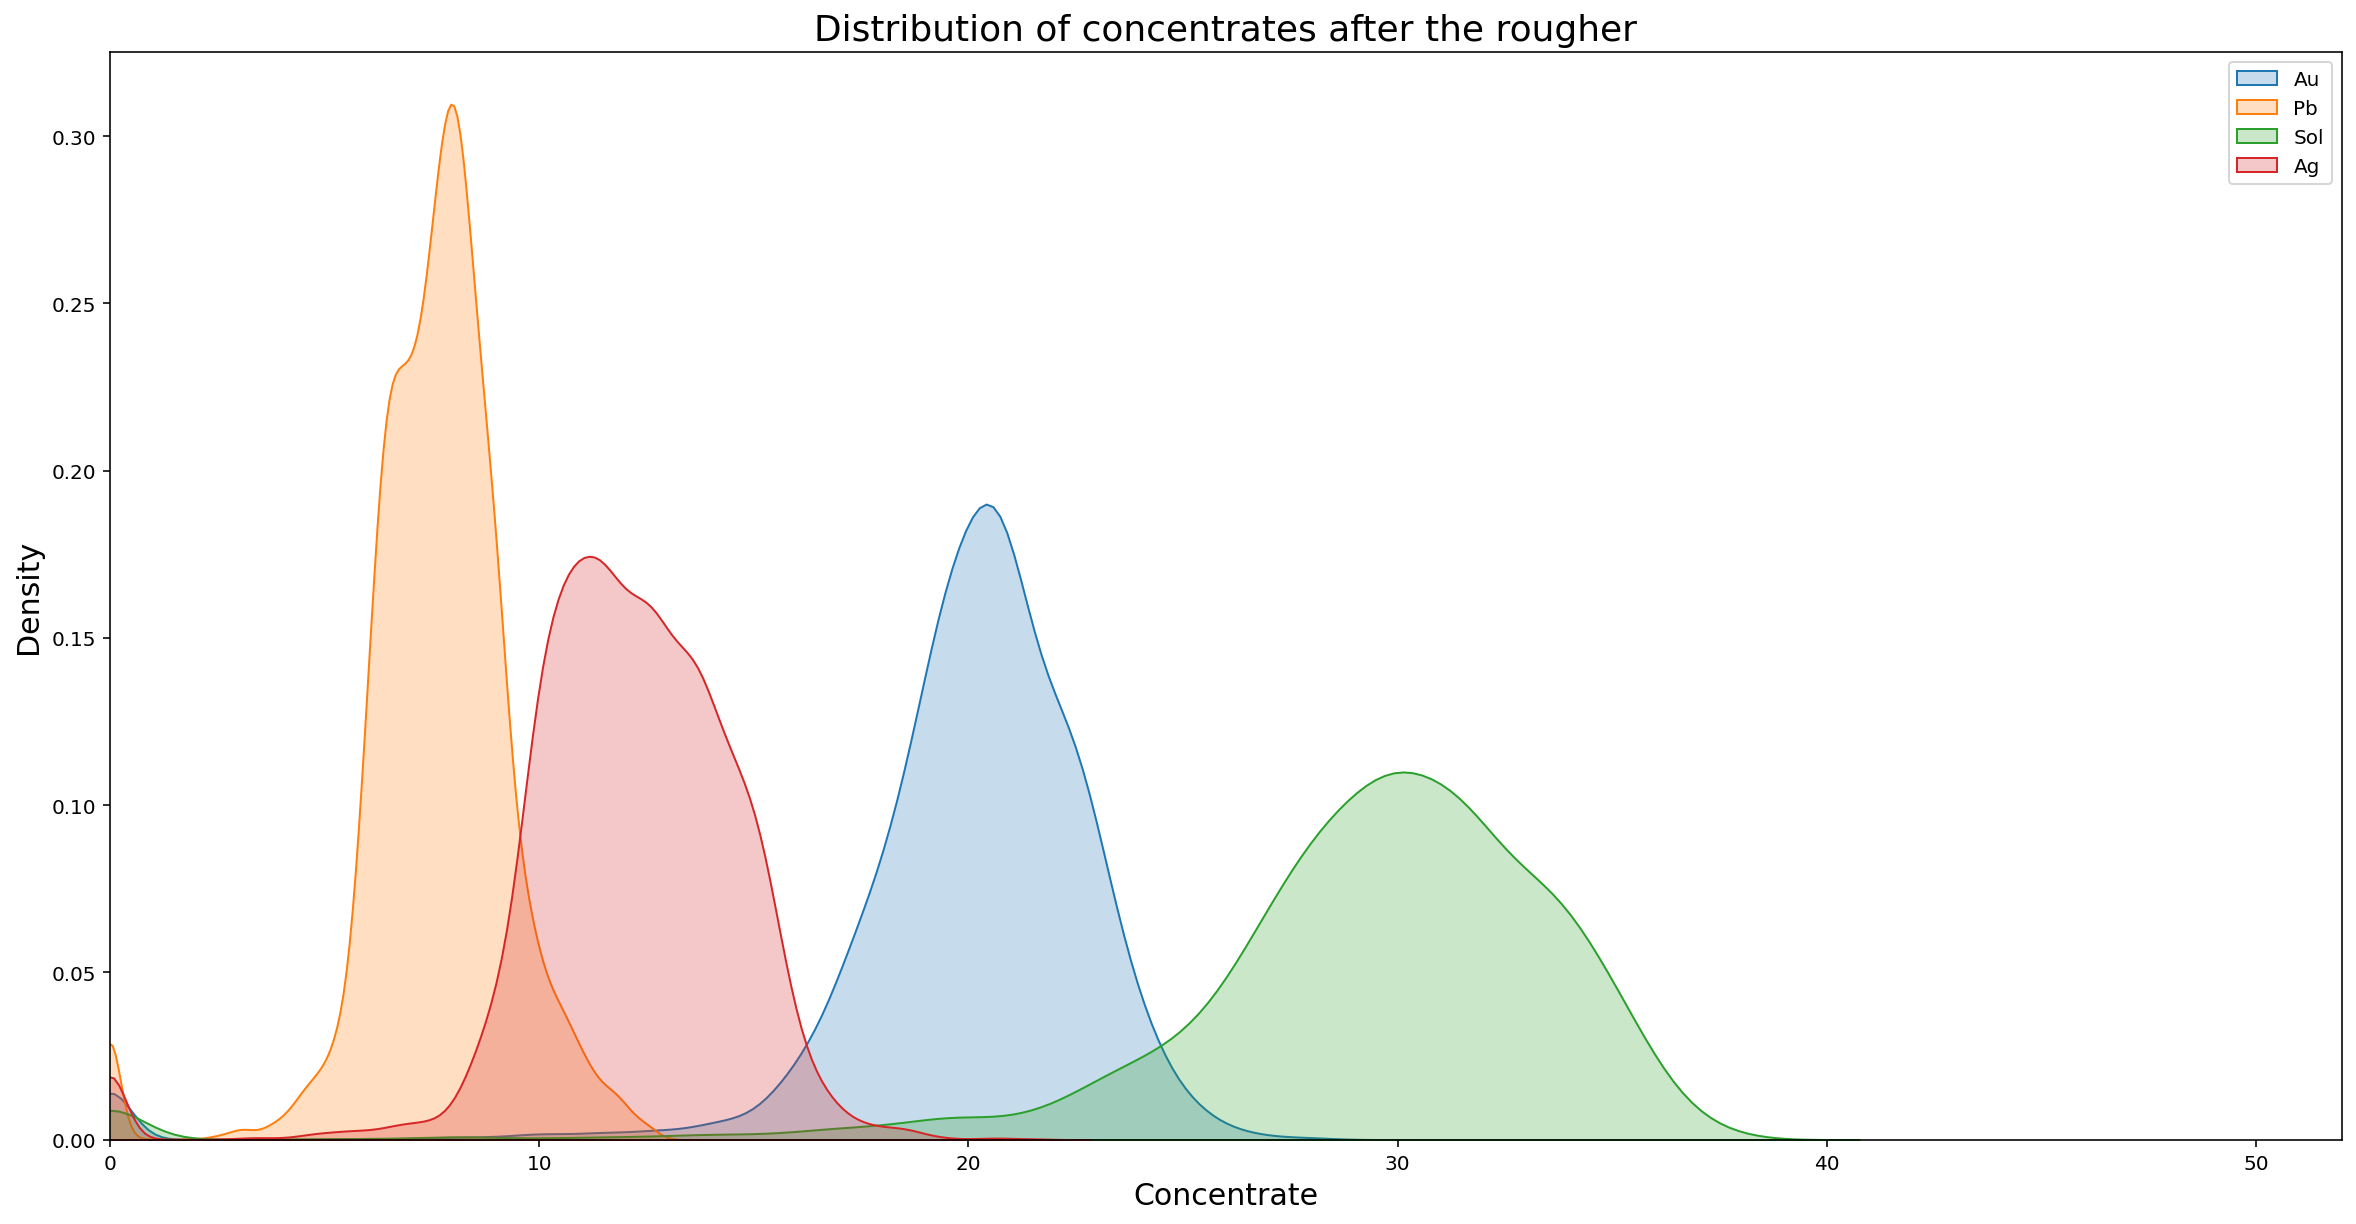

In [130]:
concentrate_plots(phases[1], 'Distribution of concentrates after the rougher')

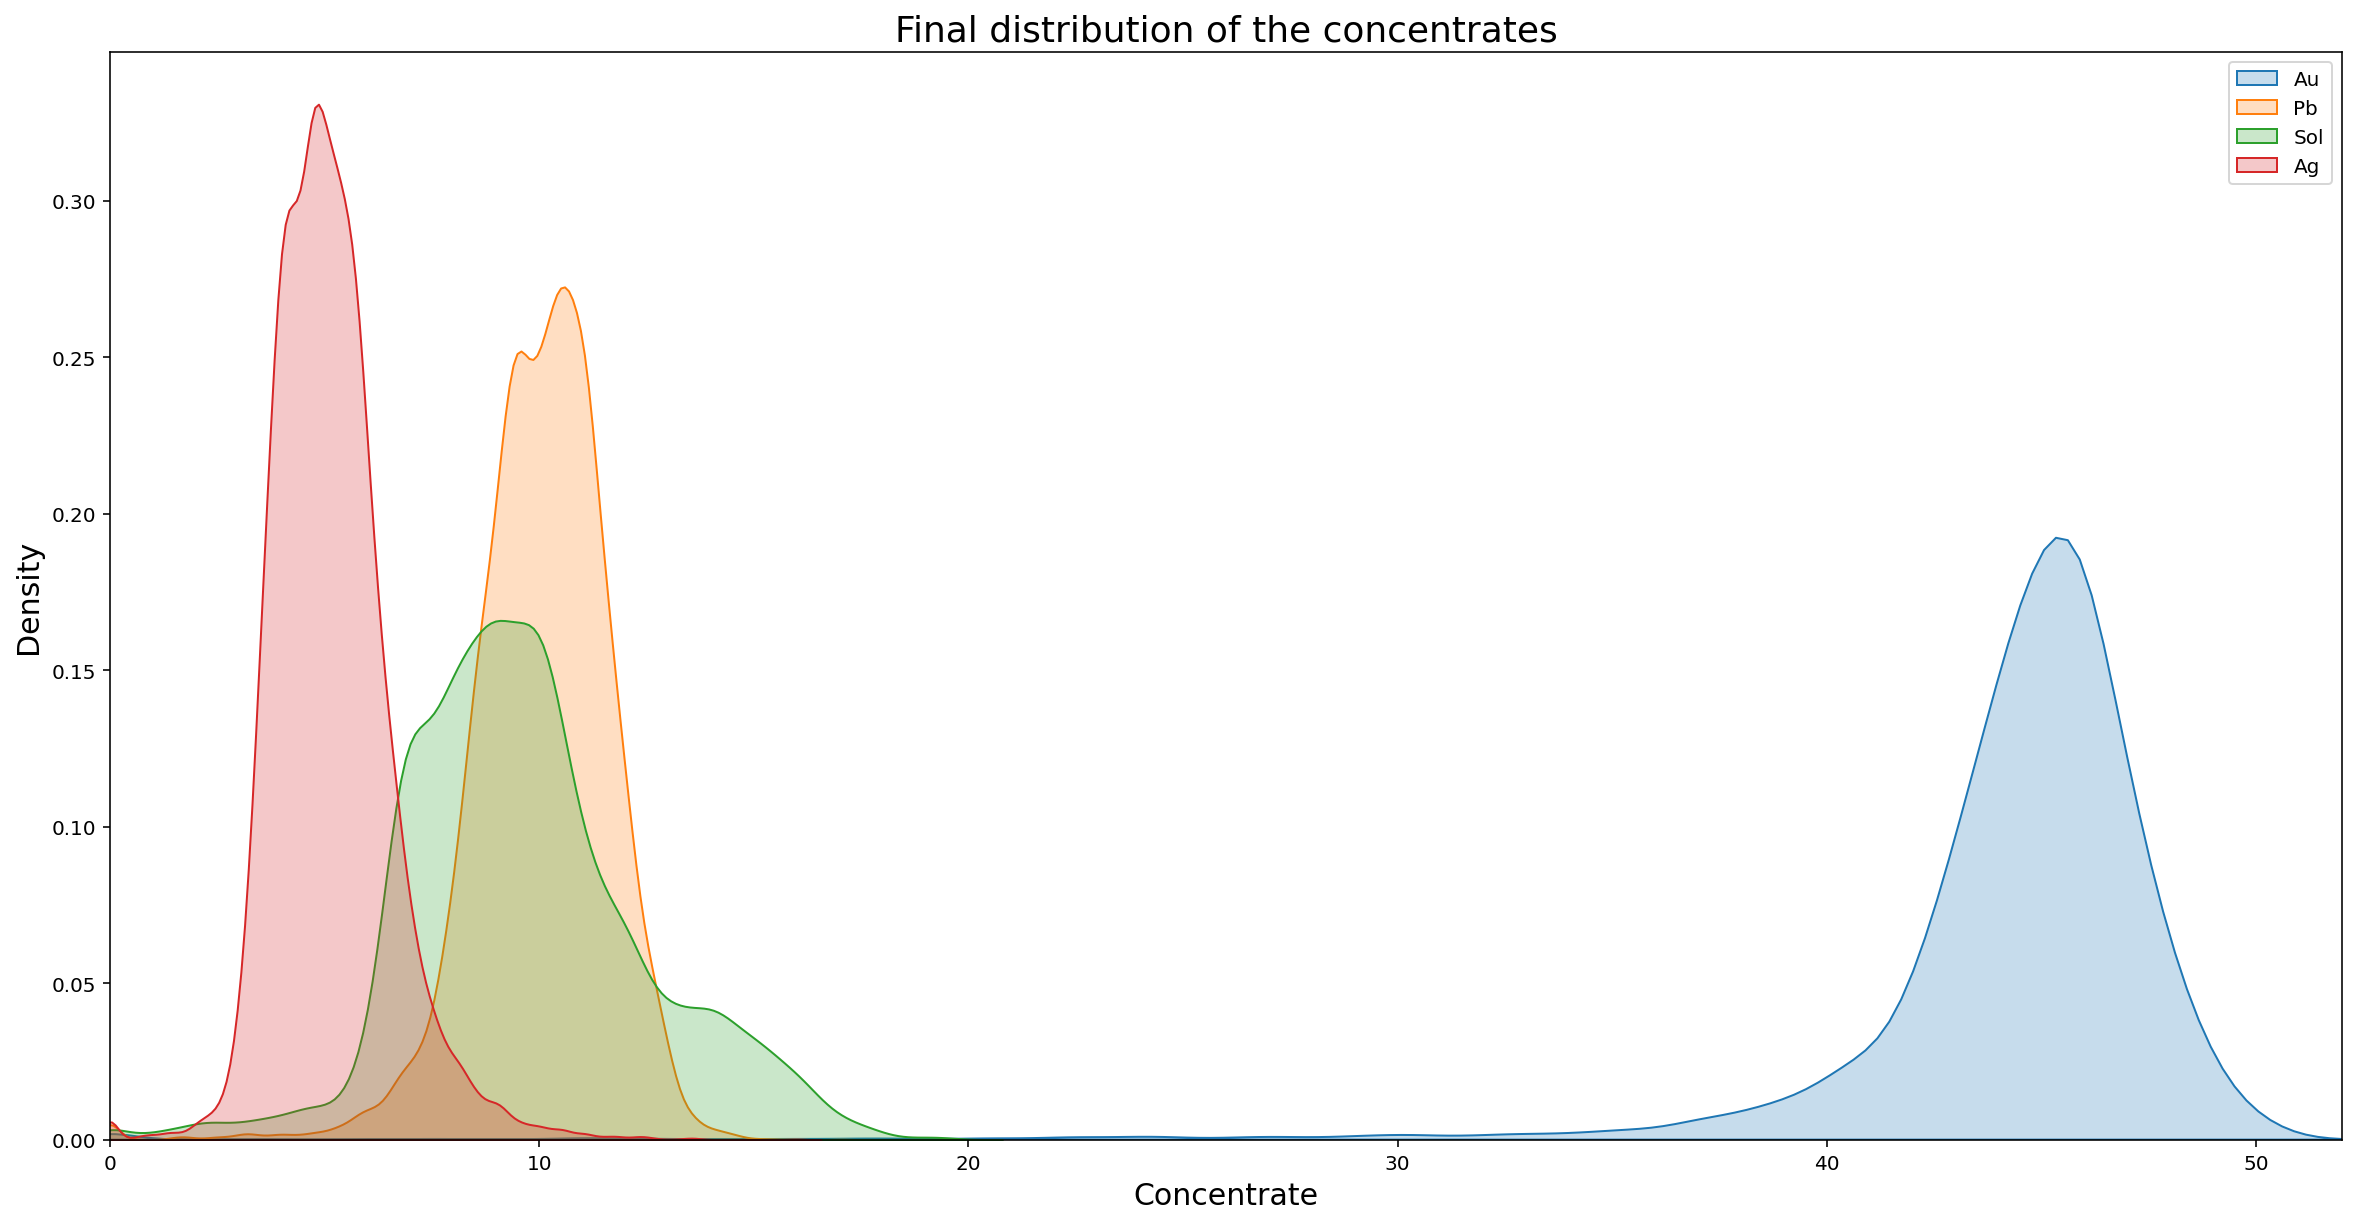

In [131]:
concentrate_plots(phases[2], 'Final distribution of the concentrates')

We can clearly see the gold concentrate climbing up after every step of purification and it's logical - it's the main goal of the company. We have several values equal to zero and it's probably an error. Let's fix it

In [132]:
for col in phases:
    for sub in substances:
        df_full = df_full[df_full[col + sub] > 0]

In [133]:
def calc_sum_phases(phase):
    
    sum_array = np.zeros(len(df_full))
    
    for substance in substances:
        sum_array += df_full[phases[phase] + substance]
    
    return sum_array

In [134]:
feed_sum = calc_sum_phases(0)
after_rougher_sum = calc_sum_phases(1)
final_sum = calc_sum_phases(2)

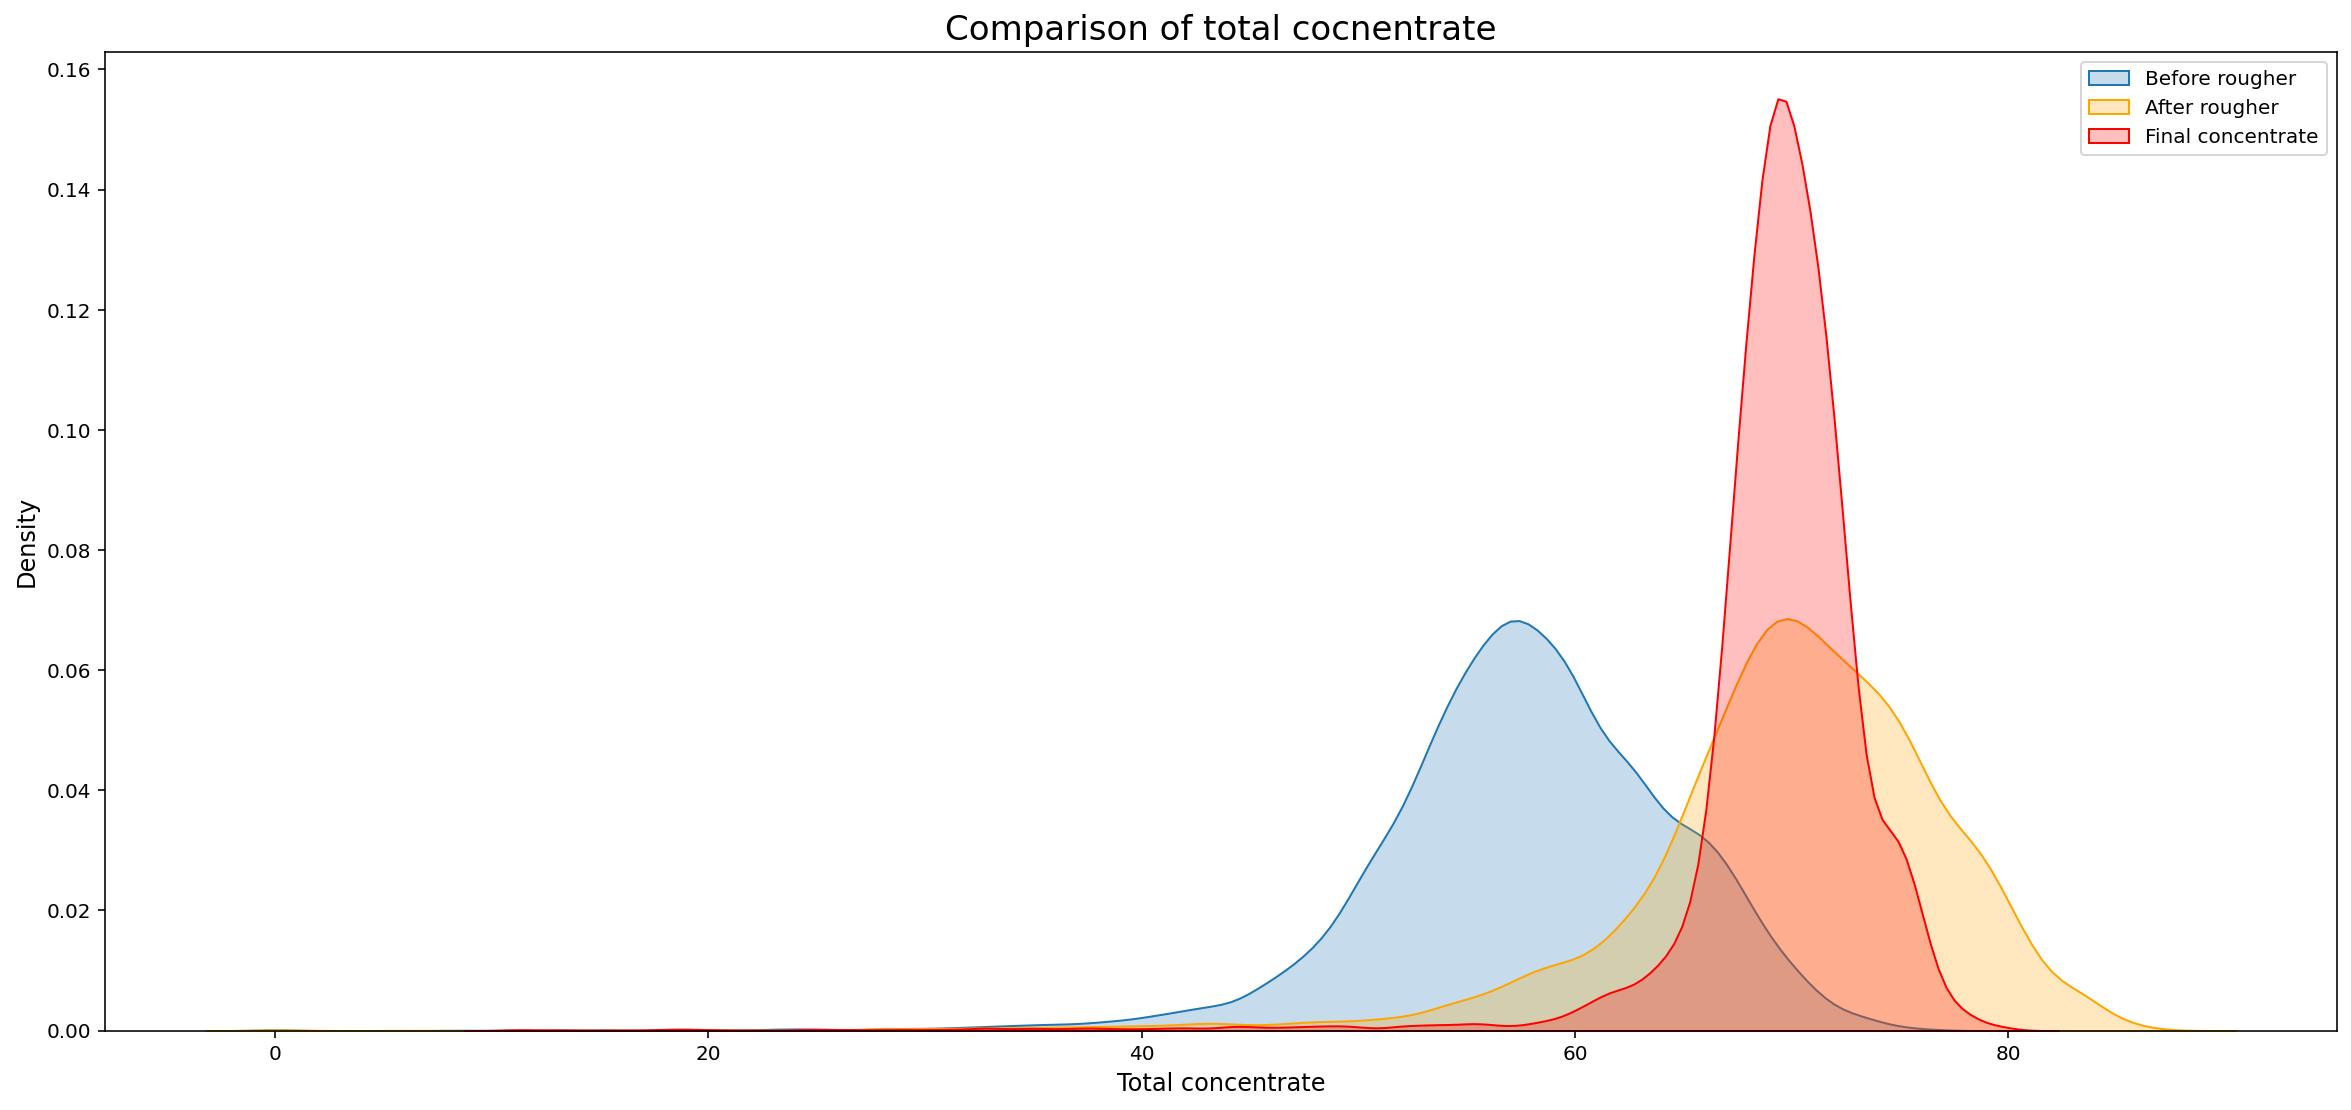

In [135]:
plt.figure(figsize=(20, 9))
sns.kdeplot(feed_sum, shade=True)
sns.kdeplot(after_rougher_sum, color='orange', shade=True)
sns.kdeplot(final_sum, color='red', shade=True)


plt.title('Comparison of total cocnentrate', size=17)
plt.xlabel('Total concentrate', size=12)
plt.ylabel('Density', size=12)
plt.legend(['Before rougher', 'After rougher', 'Final concentrate']);

In [136]:
(after_rougher_sum.mean() - feed_sum.mean()) / feed_sum.mean()

0.2085976693410798

In [137]:
feed_sum.var(), after_rougher_sum.var(), final_sum.var()

(45.35972141440203, 56.253299122351976, 23.945415861771192)

The total concentration increases by an average of 20 percent after flotation. There is no particular difference in average concentration after flotation and final concentration. The difference between stages consists only in a significantly smaller spread for the final concentration.

# Models

We're ready to find the best model for predictions using the <code> sMAPE </code> metric

In [138]:
def smape_est(estimator, X, y):
    prediction = estimator.predict(X)
    return prediction

def smape(y, y_hat):    
    return (np.sum(((abs(y - y_hat)) / ((abs(y) + abs(y_hat)) / 2)) * 100)) / len(y)


smape_scorer = make_scorer(smape, greater_is_better=False)

In [139]:
def final_smape(y_rougher, y_final, y_hat_rougher, y_hat_final):
    return 0.25 * smape(y_rougher, y_hat_rougher) + 0.85 * smape(y_final, y_hat_final)

The model will predict the output for two disticts phases - we'll have two target features

In [140]:
y_rougher = df_full['rougher.output.recovery'].reindex(df_train.index).dropna()
y_final = df_full['final.output.recovery'].reindex(df_train.index).dropna()

y_rougher_true = df_full['rougher.output.recovery'].reindex(df_test.index).dropna()
y_final_true = df_full['final.output.recovery'].reindex(df_test.index).dropna()

df_test = df_test.reindex((set(y_rougher_true.index).intersection(y_final_true.index)))

In [141]:
y_rougher_true.shape, y_final_true.shape, df_test.shape, y_rougher.shape, y_final.shape, df_train.shape

((5033,), (5033,), (5033, 52), (12009,), (12009,), (12245, 52))

In [142]:
def final_result(model_1, model_2):
    model_1.fit(X, y_rougher)
    pred_rougher = model_1.predict(X_test)
    model_2.fit(X, y_final)
    pred_final = model_2.predict(X_test)
    
    return final_smape(y_rougher_true, y_final_true, pred_rougher, pred_final)

In [143]:
scaler = StandardScaler()
scaler.fit(df_train.reindex(y_rougher.index))
X = scaler.transform(df_train.reindex(y_rougher.index))
X_test = scaler.transform(df_test)

In [144]:
# Models
lr = LinearRegression()
rf = RandomForestRegressor()
svr = SVR()
cat = CatBoostRegressor()

In [145]:
cat_params = {
    'depth': [6,8,10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [30, 50, 100]
}

rf_params = {
    'n_estimators': [10, 50,100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split' : [2,4,8],
    'bootstrap': [True, False],
}

svr_params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

In [146]:
#Let's check the linear regression first
lr_final = clone(lr, safe=True)
lr.fit(X, y_rougher)
lr_final.fit(X, y_final)

lr_rougher_predict = lr.predict(X_test)

lr_final_predict = lr_final.predict(X_test)

In [147]:
y_rougher_true.isna().sum()

0

In [148]:
lr_score = final_smape(y_rougher_true, y_final_true, lr_rougher_predict, lr_final_predict)

In [149]:
lr_score

8.381784725768657

Linear regression showed a sMAPE of 8.38. The smaller it is the better

In [150]:
%%script echo best param : 'kernel': rbf
#Проверим работу векторной машины

svr_grid = GridSearchCV(svr, svr_params, scoring=smape_scorer, cv=5, verbose=1, n_jobs=-1)
svr_grid.fit(X, y_rougher)

best param : kernel: rbf


In [151]:
abs(svr_grid.best_score_)

3.0110268121309085

In [152]:
svr_grid.best_params_

{'kernel': 'rbf'}

In [153]:
svr_1 = SVR(kernel='rbf')
svr_2 = clone(svr_1, safe=True)

In [154]:
final_result(svr_1, svr_2)

7.917643617616291

The final result for SVR is - 7.917. Slightly better than for linear regression

In [155]:
%%script echo skipping because of long calculations

forest_grid = GridSearchCV(rf, rf_params, scoring=smape_scorer, cv=5, verbose=1, n_jobs=-1)
forest_grid.fit(X, y_rougher)

skipping because of long calculations


In [156]:
forest_best_params = {'bootstrap': False,
 'max_features': 'sqrt',
 'min_samples_split': 4,
 'n_estimators': 100}

In [157]:
rf_1 = RandomForestRegressor(**forest_best_params, random_state=48)
rf_2 = clone(rf_1, safe=True)

In [158]:
final_result(rf_1, rf_2)

8.526394801709511

The random forest performs even worse than linear regression

In [159]:
%%script echo skipping because of long calculations
# Проверим Catboost
cat_grid = GridSearchCV(cat, cat_params, scoring=smape_scorer, cv=5, verbose=1, n_jobs=-1)
cat_grid.fit(X, y_rougher)

skipping because of long calculations


In [160]:
cat_best_params = {
    'depth': 10,
    'iterations': 100,
    'learning_rate': 0.1
}

In [161]:
cat_1 = CatBoostRegressor(**cat_best_params, random_seed=48)
cat_2 = clone(cat_1, safe=True)

In [162]:
final_result(cat_1, cat_2)

0:	learn: 7.0551595	total: 59.6ms	remaining: 5.9s
1:	learn: 6.6707153	total: 111ms	remaining: 5.45s
2:	learn: 6.3218930	total: 164ms	remaining: 5.29s
3:	learn: 6.0195549	total: 217ms	remaining: 5.2s
4:	learn: 5.7598695	total: 267ms	remaining: 5.08s
5:	learn: 5.5305155	total: 321ms	remaining: 5.03s
6:	learn: 5.3048133	total: 371ms	remaining: 4.92s
7:	learn: 5.1129313	total: 422ms	remaining: 4.85s
8:	learn: 4.9270788	total: 475ms	remaining: 4.8s
9:	learn: 4.7508341	total: 526ms	remaining: 4.73s
10:	learn: 4.6030425	total: 579ms	remaining: 4.68s
11:	learn: 4.4872897	total: 631ms	remaining: 4.62s
12:	learn: 4.3751033	total: 683ms	remaining: 4.57s
13:	learn: 4.2746749	total: 734ms	remaining: 4.51s
14:	learn: 4.1734435	total: 786ms	remaining: 4.45s
15:	learn: 4.0784490	total: 841ms	remaining: 4.42s
16:	learn: 4.0117031	total: 888ms	remaining: 4.34s
17:	learn: 3.9510837	total: 945ms	remaining: 4.3s
18:	learn: 3.8956719	total: 992ms	remaining: 4.23s
19:	learn: 3.8306045	total: 1.05s	remaining:

62:	learn: 4.3224563	total: 3.46s	remaining: 2.03s
63:	learn: 4.3065715	total: 3.52s	remaining: 1.98s
64:	learn: 4.2880771	total: 3.58s	remaining: 1.93s
65:	learn: 4.2666574	total: 3.63s	remaining: 1.87s
66:	learn: 4.2475806	total: 3.68s	remaining: 1.81s
67:	learn: 4.2300030	total: 3.73s	remaining: 1.76s
68:	learn: 4.2160731	total: 3.78s	remaining: 1.7s
69:	learn: 4.1928384	total: 3.84s	remaining: 1.64s
70:	learn: 4.1741190	total: 3.89s	remaining: 1.59s
71:	learn: 4.1628715	total: 3.94s	remaining: 1.53s
72:	learn: 4.1449904	total: 3.99s	remaining: 1.48s
73:	learn: 4.1337126	total: 4.04s	remaining: 1.42s
74:	learn: 4.1199258	total: 4.09s	remaining: 1.36s
75:	learn: 4.1029385	total: 4.14s	remaining: 1.31s
76:	learn: 4.0893805	total: 4.2s	remaining: 1.25s
77:	learn: 4.0787282	total: 4.24s	remaining: 1.2s
78:	learn: 4.0625688	total: 4.3s	remaining: 1.14s
79:	learn: 4.0532385	total: 4.34s	remaining: 1.08s
80:	learn: 4.0382058	total: 4.39s	remaining: 1.03s
81:	learn: 4.0221628	total: 4.44s	r

7.809979214092815

Catboost showed the best results

# Общий вывод

The best model is catboost with a <code> sMAPE = 7.286 </code>